# Control Optimisation Baselines for Tidal Range Structures - CoBaseTRS

In this notebook six state-of-the-art approaches for control optimisation of Tidal Range Structures are defined and applied to the case study of the Swansea Bay Tidal Lagoon.

The input data, numbered from 1 to 26 considers real (measured) and predicted ocean water levels at Mumbles station, located in the Bristol Channel. These data were provided by the British Oceanographic Data Center (BODC). Further details for these data can be found in the published article:

https://doi.org/10.1016/j.oceaneng.2022.110657 MOREIRA, TULIO MARCONDES; FARIA JR, JACKSON GERALDO; VAZ DE MELO, PEDRO O.S.;
CHAIMOVICZ, L; MEDEIROS-RIBERO G.. Prediction-Free, Real-Time Flexible Control of Tidal Lagoons through Proximal Policy Optimisation – A Case Study for the Swansea Lagoon, Ocean Engineering, v. 247, p. 110657, 2022.

All optimisation methods are aimed to maximise the total extracted energy, given an input ocean signal.

## Installation:

For running this notebook, we recommend having Anaconda installed. The packages required for running this notebook are pandas, matplotlib, numpy and scipy. You can install all dependencies through the command: pip install pandas matplotlib numpy scipy. Having Jupyter in your system (installed with Anaconda) is also required.

For running this Jupyter notebook, copy all files from the github repository into the same folder.

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plot
import scipy.optimize as opt

# 0D Tidal Lagoon Model Parameters

Variable Lagoon Area Al, digitised from article:

Xue, Jingjing, Reza Ahmadian, and Roger A. Falconer. "Optimising the operation of tidal range schemes." Energies 12.15 (2019): 2870.

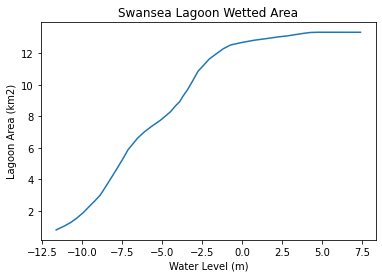

In [5]:
# import lagoon area as a function of bathymetry - Swansea Bay Tidal Lagoon model.
Al = np.genfromtxt('_wansea.csv', delimiter=',') 

fig, ax1 = plt.subplots()

ax1.set_xlabel('Water Level (m)')
ax1.set_ylabel('Lagoon Area (km2)')
ax1.set_title('Swansea Lagoon Wetted Area')
ax1.plot(Al[:,0], Al[:,1])
ax1.tick_params(axis='y')

Functions for simulating turbine operation (power generation and idling modes) and sluice gates.

All models assume 1 min. time-step (Minscale = 60 used for data convertion x/s to x/min).

In [6]:
# Andritz Turbine Eq. for estimating flow rate and power generation
def PowerGen(g,rho,nt,Sp,Dt,To,CE,Ca, head, nTurb, MinScale, top):
  if (np.abs(head) >= 1 and top == "powerGen"): # Minimum head of 1m for Power Gen.
    n11 = Sp*Dt/np.sqrt(np.abs(head));
    if n11 <= 255:
      Q11 = 0.017*n11 + 0.49;
    elif n11 > 255:
      Q11 = 4.75;
    Eff = (-0.0019*n11 + 1.2461)*CE; # Turbine Efficiency
    if Eff <=0:
      Eff = 0;
    elif Eff >= .95:
      Eff = .95;
    if (To == 1): # Flood Orientation
      if head < 0: # Ebb Gen
        Eff = 0.90*Eff;
    elif(To == 2): # Ebb Orientation
      if head > 0: # Flood Gen
        Eff = 0.90*Eff;
    Qt = nt*np.sign(head)*Q11*Dt**2*np.sqrt(np.abs(head)); # Andritz chart
    Pow = np.abs(rho*g*head*Qt)*Eff;
    if (Ca != 0) and (Pow > nt*Ca):
      POW = nt*Ca # Ca = turbine capacity (20MW for the Swansea Lagoon)
      QT = np.sign(head)*POW/(rho*g*np.abs(head)*Eff) # Dividing by Eff increases flow-rate above Ca (conservative)
    else:
      POW = Pow
      QT = Qt
    QTc = QT * MinScale;
    En = POW * MinScale * 10**-6; # Converting to MJ
  else:
    QTc = 0;
    En = 0;
  return QTc, En

In [7]:
# Orifice Eq. for idling turbines
def idling(g,rho,head,At,nt,CDt,sop,MinScale):
  if (sop == "sluicing"):
    Qs = nt*np.sign(head)*CDt*At*np.sqrt(2*g*np.abs(head))
  else:
    Qs = 0
  return Qs* MinScale

In [8]:
# Orifice Eq, for sluice gates.
def sluices(g,rho,head,As,CD,sop,MinScale):
  if (sop == "sluicing"):
    Qs = np.sign(head)*CD*As*np.sqrt(2*g*np.abs(head))
  else:
    Qs = 0
  return Qs* MinScale

Define TRS fixed parameters. For the Swansea Bay Tidal Lagoon case study:

In [9]:
# Delta time:
MinScale = 60; # (60s/m)
# Physical and Tidal Lagoon Coefficients
To = 2; # Turbine Orientation -> To = 2: Ebb Orientation (Penalty when generating energy during Flood Generation)
g = 9.81; # Gravity acceleration (m/s2)
rho = 1024; # Seawater density (kg/m3)
nt = 16; # Number of turbines
f = 50; # Grid frequency (Hz)
Np = 95; # Number of generator poles in the turbine. Ref: Angeloudis, Athanasios, et al. "Comparison of 0-D, 1-D and 2-D model capabilities for tidal range energy resource assessments." (2017)
Dt = 7.35; # Bulb turbine diameter (m).
Ca = 20 * 10**6; # (All 16 units = 20MW)
CD = 1;
CDt = 1.36; # Turbine Discharge Coefficient when running in Idling mode. Ref: Angeloudis, Athanasios, et al. "Comparison of 0-D, 1-D and 2-D model capabilities for tidal range energy resource assessments." (2017)
Sp = 2 * 60 * f / Np; # Turbine speed. Ref: Angeloudis, Athanasios, et al. "Comparison of 0-D, 1-D and 2-D model capabilities for tidal range energy resource assessments." (2017)
At = np.pi * Dt**2 / 4;
As = 800; # # Angeloudis, Athanasios, et al. "Comparison of 0-D, 1-D and 2-D model capabilities for tidal range energy resource assessments." (2017)
# Barrage Losses ( Aggidis - Operational optimization of a tidal barrage across the Mersaey Estuary)
Eff_ge = .97; # Generator Efficiency (Andre, 1976)
Eff_te = .995; # Transformer Efficiency (Libaux et al, 2011)
Eff_we = .95; # Water Friction (Baker and Leach, 2006)
Eff_gear_box_e = .972; # Gear Box/Drive train (Taylor, 2008)
Eff_turbine_avail = .95; # Turbine availlability in lifecycle (Baker and Leach, 2006)
CE = Eff_ge * Eff_te * Eff_we * Eff_gear_box_e * Eff_turbine_avail; # Turbine local efficiency losses - Calculated in Awake
# Momentum Ramp Parameter
Zeta = 0.4

In [10]:
%run TidalLagoonFunctions.ipynb # Import 0D model simulation and optimization routines

# Load & Preprocess BODC (prediction & measurements) files

### Choose data for operation and make resolution = 1 min

In [11]:
def GetDataBODC(ii):
   
    file = str(ii) + 'r.csv' # BODC 'r = real' measurement files
    my_data = genfromtxt(file)
    owl_real_load = my_data[:] ;
    owl_real_15min = owl_real_load # - np.mean(owl_real_load);
    time = np.linspace(0,(1/4)*(owl_real_15min.shape[0]-1),owl_real_15min.shape[0])
    
    fileb = str(ii) + 'p.csv' # BODC 'p = prediction' files
    my_datab = genfromtxt(fileb)
    owl_b_load = my_datab[:] ;
    owl_bp_15min = owl_b_load # - np.mean(owl_b_load);
    timeb = np.linspace(0,(1/4)*(owl_bp_15min.shape[0]-1),owl_bp_15min.shape[0])
    
    # Make BODC file resolution = 1 min (instead of 15 min)
    
    # BODC real data: 
    stop = 24*4*30 # Last point number to complete a month (deltaT =  15 min) 
    kk = 0; jj = 0;
    owl_real_min = []
    while kk < stop: 
        temp = (owl_real_15min[kk]*(15-jj)/15 + (jj/15)*owl_real_15min[kk+1])
        owl_real_min.append(temp)
        if (jj % 15 == 0 and jj != 0): # 15 minutes passed
            jj = 0;
            kk += 1
        jj += 1 
        
    # BODC prediction data: 
    stop = 24*4*30 # Last point number to complete a month (deltaT =  15 min) 
    kk = 0; jj = 0;
    owl_BODCp_min = []
    while kk < stop: 
        temp = (owl_bp_15min[kk]*(15-jj)/15 + (jj/15)*owl_bp_15min[kk+1])
        owl_BODCp_min.append(temp)
        if (jj % 15 == 0 and jj != 0): # 15 minutes passed
            jj = 0;
            kk += 1
        jj += 1 
    
    timeMin = np.linspace(0, len(owl_bp_15min)-1, len(owl_bp_15min)) # Time, by the minute
    
    return owl_real_min, owl_BODCp_min, timeMin, owl_real_15min, owl_bp_15min

Cut every half-tide for BODC datasets. This process utilises ocean data with time resolution = 15 min.

In [12]:
def returStartEndHT(ocean15MinRes):
    # 1st time reading ocean data, first change in sign (ocean) = first cut
    # 2nd cut, and so forth, are found when the derivative (ocean[kk+1] + ocean[kk]) switches sign
    StartEndHT = []
    ii = 0
    delta = 0
    StartEndHT.append(ii)
    derivSignalI = np.sign(ocean15MinRes[2] - ocean15MinRes[1]); # Initial slope
    for owl in ocean15MinRes[0:-1]:
        if (ocean15MinRes[ii+1] != owl) and delta > 10: # Ignore small perturbations
            derivSignal = np.sign(ocean15MinRes[ii+1] - owl)
            if (derivSignal != derivSignalI):
                StartEndHT.append(ii)
                derivSignalI = derivSignal
                delta = 0
        ii += 1
        delta +=1 
    
    return StartEndHT

Create tolerance parameter (MaxDelta) for considering oceanWl = lagoon Wl. Used for all optimisation functions.

In [13]:
Data = 1
owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
StartEndHT = returStartEndHT(owl_pb_15)

In [14]:
MaxDelta = 0
kk = 0
for wl in owl_r[0:-1]:
    MaxTemp = np.abs(owl_pb[kk] - owl_pb[kk+1]) 
    if MaxTemp > MaxDelta:
        MaxDelta = MaxTemp
    kk+=1
print(MaxDelta)

0.047000000000000014


# Choose month (or multiple months) for running all optimisation methods:

In [57]:
Months = [1]
# For running all 26 months use:
# Months = np.arange(1,27)

# CH Routine

Constant (optimum) Hstart and Hmin operational heads are applied to the full input data (one month, for this study)

In [15]:
def CHgetEnergyFromData(oceanData): 
    resVec = [1, .5, .25, .125, .0625, .03125, 0.015625, 0.0078125] # Difference in cm between operational head tested
    iteration = 0
    MaxEnBS1 = 0
    HminBegin = 1
    HminEnd = 3
    HstartBegin = 1
    HstartEnd = 6
    
    Fl = 0; Fp = 0; Fqt = 0; Fqs = 0
    for res in resVec:
        # Brute Force optimization (Find best Hstart and Hmin for a whole month):
        if iteration != 0:

            HstartBegin = BestConfig[0] - res
            HstartEnd   = BestConfig[0] + res
            HminBegin   = BestConfig[1] - res
            HminEnd     = BestConfig[1] + res

        numberHmin = int(1 + (HminEnd - HminBegin)/res)
        numberHstart = int(1 + (HstartEnd - HstartBegin)/res)
        for Hmin in np.linspace(HminBegin, HminEnd, numberHmin):
            for Hstart in np.linspace(HstartBegin, HstartEnd, numberHstart):
                Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOP(Hstart, Hmin, oceanData)
                if (EnOut > MaxEnBS1):
                    MaxEnBS1 = EnOut
                    Fl = Lagoon; Fp = Power; Fqt = Qturbine; Fqs = Qsluice
                    BestConfig = [Hstart, Hmin]
                iteration += 1
                    
    return MaxEnBS1, BestConfig, Fl, Fp, Fqt, Fqs

Get Upper Bound estimate (perfect forecast scenario) for CH method

In [60]:
CHUpperBoundEn = []; CHUpperBoundLagoon = []; CHUpperBoundOcean = []; CHUpperBoundStrategy = []
CHUpperBoundQt = []; CHUpperBoundQs = []; CHUpperBoundPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    MaxEn, BestHstartHmin, Lagoon, Power, Qturbine, Qsluice = CHgetEnergyFromData(owl_r)
    CHUpperBoundEn.append(MaxEn/(3.6*10**6)) # Total energy (in GWh)
    CHUpperBoundLagoon.append(Lagoon) # Lagoon water level  (in meters)
    CHUpperBoundOcean.append(owl_r) # Ocean water level (in meters)
    CHUpperBoundQt.append(Qturbine) # Total turbine flow rate (in meters^3/second)
    CHUpperBoundQs.append(Qsluice) # Total sluice flow rate (in meters^3/second)
    CHUpperBoundPow.append(Power) # Power generation (in MW)
    CHUpperBoundStrategy.append(BestHstartHmin) # Optimised operational heads

In [61]:
CHUpperBoundEn

[33.65276823519373]

Get Real-Time estimate when using a whole month of tidal prediction data

In [18]:
CHMonthPredEn = []; CHMonthPredLagoon = []; CHMonthPredOcean = []; CHMonthPredStrategy = []
CHMonthPredQt = []; CHMonthPredQs = []; CHMonthPredPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    _, BestHstartHmin, _, _, _, _ = CHgetEnergyFromData(owl_pb)
    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOP(BestHstartHmin[0], BestHstartHmin[1], owl_r)
    CHMonthPredEn.append(EnOut/(3.6*10**6)) # Total energy (in GWh)
    CHMonthPredLagoon.append(Lagoon) # Lagoon water level  (in meters)
    CHMonthPredOcean.append(owl_r) # Ocean water level (in meters)
    CHMonthPredQt.append(Qturbine) # Total turbine flow rate (in meters^3/second)
    CHMonthPredQs.append(Qsluice) # Total sluice flow rate (in meters^3/second)
    CHMonthPredPow.append(Power) # Power generation (in MW)
    CHMonthPredStrategy.append(BestHstartHmin) # Optimised operational heads

In [19]:
CHMonthPredEn

[32.04206072869234]

# CHV Routine

Constant (optimum) Hstart, Hmin and Hsstart (for independent sluice operation) operational heads are applied to the full input data (one month, for this study)

In [20]:
def CHVgetEnergyFromData(oceanData): 
    resVec = [1, .5, .25, .125, .0625, .03125, 0.015625, 0.0078125] # Difference in cm between operational head tested
    iteration = 0
    MaxEnB2 = 0
    HminBegin = 1
    HminEnd = 3
    HstartBegin = 1
    HstartEnd = 6
    HsStartBegin = 1
    HsStartEnd = 5
    
    Fl = 0; Fp = 0; Fqt = 0; Fqs = 0
    for res in resVec:
        # Brute Force optimization (Find best Hstart and Hmin for a whole month):
        if iteration != 0:

            HstartBegin    = BestConfig[0] - res
            HstartEnd     = BestConfig[0] + res
            HminBegin      = BestConfig[1] - res
            HminEnd       = BestConfig[1] + res
            HsStartBegin   = BestConfig[2] - res
            HsStartEnd    = BestConfig[2] + res

        numberHmin = int(1 + (HminEnd - HminBegin)/res)
        numberHstart = int(1 + (HstartEnd - HstartBegin)/res)
        numberHsStart = int(1 + (HsStartEnd - HsStartBegin)/res)
        
        for HtMin in np.linspace(HminBegin, HminEnd, numberHmin):
            for HtStart in np.linspace(HstartBegin, HstartEnd, numberHstart):
                for HsStart in np.linspace(HsStartBegin, HsStartEnd, numberHsStart):
                    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOPB2(HtStart, HtMin, HsStart, oceanData)
                    if (EnOut > MaxEnB2):
                        MaxEnB2 = EnOut
                        Fl = Lagoon; Fp = Power; Fqt = Qturbine; Fqs = Qsluice
                        BestConfig = [HtStart, HtMin, HsStart]
                    iteration += 1
                    
    return MaxEnB2, BestConfig, Fl, Fp, Fqt, Fqs

Get Upper Bound estimate (perfect forecast scenario) for CHV method

In [21]:
CHVUpperBoundEn = []; CHVUpperBoundLagoon = []; CHVUpperBoundOcean = []; CHVUpperBoundStrategy = []
CHVUpperBoundQt = []; CHVUpperBoundQs = []; CHVUpperBoundPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    MaxEn, BestHstartHmin, Lagoon, Power, Qturbine, Qsluice = CHVgetEnergyFromData(owl_r)
    CHVUpperBoundEn.append(MaxEn/(3.6*10**6)) # Total energy (in GWh)
    CHVUpperBoundLagoon.append(Lagoon) # Lagoon water level  (in meters)
    CHVUpperBoundOcean.append(owl_r) # Ocean water level (in meters)
    CHVUpperBoundQt.append(Qturbine) # Total turbine flow rate (in meters^3/second)
    CHVUpperBoundQs.append(Qsluice) # Total sluice flow rate (in meters^3/second)
    CHVUpperBoundPow.append(Power) # Power generation (in MW)
    CHVUpperBoundStrategy.append(BestHstartHmin) # Optimised operational heads

In [22]:
CHVUpperBoundEn

[34.13585825212925]

Get Real-Time estimate when using a whole month of tidal prediction data

In [23]:
CHVMonthPredEn = []; CHVMonthPredLagoon = []; CHVMonthPredOcean = []; CHVMonthPredStrategy = []
CHVMonthPredQt = []; CHVMonthPredQs = []; CHVMonthPredPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    _, BestHstartHminHSstart, _, _, _, _, = CHVgetEnergyFromData(owl_pb)
    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOPB2(BestHstartHminHSstart[0], BestHstartHminHSstart[1], BestHstartHminHSstart[2], owl_r)
    CHVMonthPredEn.append(EnOut/(3.6*10**6)) # Total energy (in GWh)
    CHVMonthPredLagoon.append(Lagoon) # Lagoon water level  (in meters)
    CHVMonthPredOcean.append(owl_r) # Ocean water level (in meters)
    CHVMonthPredQt.append(Qturbine) # Total turbine flow rate (in meters^3/second)
    CHVMonthPredQs.append(Qsluice) # Total sluice flow rate (in meters^3/second)
    CHVMonthPredPow.append(Power) # Power generation (in MW)
    CHVMonthPredStrategy.append(BestHstartHminHSstart) # Optimised operational heads

In [24]:
CHVMonthPredEn

[32.38642729603018]

# EHT Routine

Best Hstart and Hmin operational heads are found for every half-tide and applied to the full input data (one month, for this study)

In [25]:
def EHTgetEnergyFromData(oceanData): # Ocean data with res = 15min

    everyHTHstartHmin = [] # Collection of tuples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nextQandEn = ehtB3(timeMin, oceanMinHT, initialLagoonElev, top, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTHstartHmin.append(BestConfig)
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
        everyHTLagoon.append(Lagoon) # Save every lagoon half-tide data with res = 1 min
        everyHTQt.append(Qturbine)
        everyHTQs.append(Qsluice)
        everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHmin

Apply BestConfig heads from EHT into ocean data:

In [26]:
def EHTapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nextQandEn = TidalLagoonOPB3(HtStart, HtMin, timeMin, oceanMin, initialLagoonElev, top, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

Get Upper Bound estimate (perfect forecast scenario) for EHT method

In [27]:
nextQandEn = [0, 0, 0]
EHTUpperBoundEn = []; EHTUpperBoundLagoon = []; EHTUpperBoundTime = []; EHTUpperBoundOcean = []; EHTUpperBoundStrategy = []
EHTUpperBoundQt = []; EHTUpperBoundQs = []; EHTUpperBoundPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    UbTest, LagoonBODC, time_np, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHmin_np = EHTgetEnergyFromData(owl_r_15)
    EHTUpperBoundEn.append(UbTest/(3.6*10**6)) # Total energy (in GWh)
    EHTUpperBoundLagoon.append(LagoonBODC) # Lagoon water level  (in meters)
    EHTUpperBoundTime.append(time_np) # Time (in minutes)
    EHTUpperBoundOcean.append(OceanBODC) # Ocean water level (in meters)
    EHTUpperBoundQt.append(everyHTQt) # Total turbine flow rate (in meters^3/second)
    EHTUpperBoundQs.append(everyHTQs) # Total sluice flow rate (in meters^3/second)
    EHTUpperBoundPow.append(everyHTPow) # Power generation (in MW)
    EHTUpperBoundStrategy.append(everyHTHstartHmin_np) # Optimised operational heads

In [28]:
EHTUpperBoundEn

[43.72645119955317]

Get Real-Time estimate when using a whole month of tidal prediction data

In [29]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]
EHTMonthPredEn = []; EHTMonthPredLagoon = []; EHTMonthPredTime = []; EHTMonthPredOcean = []; EHTMonthPredStrategy = []
EHTMonthPredQt = []; EHTMonthPredQs = []; EHTMonthPredPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHmin = EHTgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHTSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHTapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHmin)
    EHTMonthPredEn.append(EHTSwansea_np/(3.6*10**6)) # Total energy (in GWh)
    EHTMonthPredLagoon.append(everyHTLagoon) # Lagoon water level  (in meters)
    EHTMonthPredTime.append(timeMin) # Time (in minutes)
    EHTMonthPredOcean.append(everyHTOcean) # Ocean water level (in meters)
    EHTMonthPredQt.append(everyHTQturbine) # Total turbine flow rate (in meters^3/second)
    EHTMonthPredQs.append(everyHTQsluice) # Total sluice flow rate (in meters^3/second)
    EHTMonthPredPow.append(everyHTPower) # Power generation (in MW)
    EHTMonthPredStrategy.append(everyHTHstartHmin) # Optimised operational heads

In [30]:
EHTMonthPredEn

[43.408596470700715]

# EHTV Routine

Best Hstart, Hmin and Hstart (for independent sluice operation) operational heads are found for every half-tide and applied to the full input data (one month, for this study)

In [31]:
def EHTVgetEnergyFromData(oceanData): # Ocean data with res = 15min

    everyHTHstartHminHsStart = [] # Collection of triples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            sop = nsop # Sequential sluice operation
            prevQandEn = nextQandEn
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nsop, nextQandEn = ehtB4(timeMin, oceanMinHT, initialLagoonElev, top, sop, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTHstartHminHsStart.append(BestConfig)
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
        everyHTLagoon.append(Lagoon) # Save every lagoon half-tide data with res = 1 min
        everyHTQt.append(Qturbine)
        everyHTQs.append(Qsluice)
        everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart

Apply BestConfig heads from EHTV into ocean data:

In [32]:
def EHTVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
#     nextQandEn = [0, 0, 0]
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        HsStart   = BestConfig[ii][2]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            sop = nsop # Sequential sluice operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nsop, nextQandEn = TidalLagoonOPB4(HtStart, HtMin, HsStart, timeMin, oceanMin, initialLagoonElev, top, sop, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

Get Upper Bound estimate (perfect forecast scenario) for EHTV method

In [33]:
nextQandEn = [0, 0, 0]
EHTVUpperBoundEn = []; EHTVUpperBoundLagoon = []; EHTVUpperBoundTime = []; EHTVUpperBoundOcean = []; EHTVUpperBoundStrategy = []
EHTVUpperBoundQt = []; EHTVUpperBoundQs = []; EHTVUpperBoundPow = []
for Data in Months:
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHTVgetEnergyFromData(owl_r_15)
    EHTVUpperBoundEn.append(BODCMonthEn/(3.6*10**6)) # Total energy (in GWh)
    EHTVUpperBoundLagoon.append(LagoonBODC) # Lagoon water level  (in meters)
    EHTVUpperBoundTime.append(time) # Time (in minutes)
    EHTVUpperBoundOcean.append(OceanBODC) # Ocean water level (in meters)
    EHTVUpperBoundQt.append(everyHTQt) # Total turbine flow rate (in meters^3/second)
    EHTVUpperBoundQs.append(everyHTQs) # Total sluice flow rate (in meters^3/second)
    EHTVUpperBoundPow.append(everyHTPow) # Power generation (in MW)
    EHTVUpperBoundStrategy.append(everyHTHstartHminHsStart) # Optimised operational heads

In [34]:
EHTVUpperBoundEn

[44.69732734959117]

Get Real-Time estimate when using a whole month of tidal prediction data

In [35]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]

EHTVMonthPredEn = []; EHTVMonthPredLagoon = []; EHTVMonthPredTime = []; EHTVMonthPredOcean = []; EHTVMonthPredStrategy = []
EHTVMonthPredQt = []; EHTVMonthPredQs = []; EHTVMonthPredPow = []
for Data in Months:
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHminHsStart_np = EHTVgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHTVSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHTVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHminHsStart_np)
    EHTVMonthPredEn.append(EHTVSwansea_np/(3.6*10**6)) # Total energy (in GWh)
    EHTVMonthPredLagoon.append(everyHTLagoon) # Lagoon water level  (in meters)
    EHTVMonthPredTime.append(timeMin) # Time (in minutes)
    EHTVMonthPredOcean.append(everyHTOcean) # Ocean water level (in meters)
    EHTVMonthPredQt.append(everyHTQturbine) # Total turbine flow rate (in meters^3/second)
    EHTVMonthPredQs.append(everyHTQsluice) # Total sluice flow rate (in meters^3/second)
    EHTVMonthPredPow.append(everyHTPower) # Power generation (in MW)
    EHTVMonthPredStrategy.append(everyHTHstartHminHsStart_np) # Optimised operational heads

In [36]:
EHTVMonthPredEn

[44.22641706058734]

# EHN Routine

Every half-tide and next. In this approach we will optimize a whole tide (2 Hstarts and 2 Hmin) and pick first Hstart and Hmin pair to operate the first half-tide. The energy is returned for one half-tide and the process is repeated. For this baseline, sluices start operating only after Hmin.

In [37]:
def EHNgetEnergyFromData(oceanData): # Ocean data with res = 15min

    everyPTHstartHmin = [] # Collection of "pair" triples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second, third in zip(StartEndHT, StartEndHT[1:], StartEndHT[2:]):
        jj = 0;
        oceanMinHT1 = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT1.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        jj = 0;
        oceanMinHT2 = [] 
        while second < third: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[second]*(15-jj)/15 + (jj/15)*oceanData[second+1])
            oceanMinHT2.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                second += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin1 = np.linspace(0, len(oceanMinHT1)-1, len(oceanMinHT1)) # Time, by the minute 1st HT
        timeMin2 = np.linspace(0, len(oceanMinHT2)-1, len(oceanMinHT2)) # Time, by the minute 2nd HT
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop1 # Sequential turbine operation
            prevQandEn = nextQandEn1
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop1, nextQandEn1 = etB3(timeMin1, oceanMinHT1, timeMin2, oceanMinHT2, initialLagoonElev, top, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTtimeMin.append(timeMin1); everyHTOcean.append(oceanMinHT1); everyPTHstartHmin.append(BestConfig)
        everyHTLagoon.append(Lagoon); everyHTQt.append(Qturbine); everyHTQs.append(Qsluice); everyHTPow.append(Power)
        if (third == StartEndHT[-1]): # Means the last tide (not accounted by etB3)
            MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nextQandEn2 = ehtB3(timeMin2, oceanMinHT2, Lagoon[-1], ntop1, nextQandEn1)
            MonthEnTraining += MaxEn
            everyHTtimeMin.append(timeMin2); everyHTOcean.append(oceanMinHT2); everyPTHstartHmin.append(BestConfig)
            everyHTLagoon.append(Lagoon); everyHTQt.append(Qturbine); everyHTQs.append(Qsluice); everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyPTHstartHmin

Get Upper Bound estimate (perfect forecast scenario) for EHN method

In [38]:
nextQandEn = [0, 0, 0]
EHNUpperBoundEn = []; EHNUpperBoundLagoon = []; EHNUpperBoundTime = []; EHNUpperBoundOcean = []; EHNUpperBoundStrategy = []
EHNUpperBoundQt = []; EHNUpperBoundQs = []; EHNUpperBoundPow = []
for Data in Months:
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHNgetEnergyFromData(owl_r_15)
    EHNUpperBoundEn.append(BODCMonthEn/(3.6*10**6)) # Total energy (in GWh)
    EHNUpperBoundLagoon.append(LagoonBODC) # Lagoon water level  (in meters)
    EHNUpperBoundTime.append(time) # Time (in minutes)
    EHNUpperBoundOcean.append(OceanBODC) # Ocean water level (in meters)
    EHNUpperBoundQt.append(everyHTQt) # Total turbine flow rate (in meters^3/second)
    EHNUpperBoundQs.append(everyHTQs) # Total sluice flow rate (in meters^3/second)
    EHNUpperBoundPow.append(everyHTPow) # Power generation (in MW)
    EHNUpperBoundStrategy.append(everyHTHstartHminHsStart) # Optimised operational heads

In [39]:
EHNUpperBoundEn

[44.059572728366106]

Get Real-Time estimate when using a whole month of tidal prediction data

In [40]:
def EHNapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nextQandEn = TidalLagoonOPB3(HtStart, HtMin, timeMin, oceanMin, initialLagoonElev, top, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

In [41]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]
EHNMonthPredEn = []; EHNMonthPredLagoon = []; EHNMonthPredTime = []; EHNMonthPredOcean = []; EHNMonthPredStrategy = []
EHNMonthPredQt = []; EHNMonthPredQs = []; EHNMonthPredPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHmin = EHNgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    
    # OLD:
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    
    EHNSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHNapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHmin)
    EHNMonthPredEn.append(EHNSwansea_np/(3.6*10**6)) # Total energy (in GWh)
    EHNMonthPredLagoon.append(everyHTLagoon) # Lagoon water level  (in meters)
    EHNMonthPredTime.append(everyHTtimeMin) # Time (in minutes)
    EHNMonthPredOcean.append(everyHTOcean) # Ocean water level (in meters)
    EHNMonthPredQt.append(everyHTQturbine) # Total turbine flow rate (in meters^3/second)
    EHNMonthPredQs.append(everyHTQsluice) # Total sluice flow rate (in meters^3/second)
    EHNMonthPredPow.append(everyHTPower) # Power generation (in MW)
    EHNMonthPredStrategy.append(everyHTHstartHmin) # Optimised operational heads

In [42]:
EHNMonthPredEn

[43.56916649942353]

# EHNV Routine

Every half-tide and next. In this approach we will optimize a whole tide (2 Hstart, 2 Hmin and 2 Hstart) and pick first Hstart, Hmin and Hstart triple to operate the first half-tide. The energy is returned for one half-tide and the process is repeated. For this baseline sluices start operating only after Hmin.

In [43]:
def EHNVgetEnergyFromData(oceanData): # Ocean data with res = 15min

    everyHTHstartHminHsStart = [] # Collection of "pair" triples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second, third in zip(StartEndHT, StartEndHT[1:], StartEndHT[2:]):
        jj = 0;
        oceanMinHT1 = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT1.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        jj = 0;
        oceanMinHT2 = [] 
        while second < third: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[second]*(15-jj)/15 + (jj/15)*oceanData[second+1])
            oceanMinHT2.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                second += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin1 = np.linspace(0, len(oceanMinHT1)-1, len(oceanMinHT1)) # Time, by the minute 1st HT
        timeMin2 = np.linspace(0, len(oceanMinHT2)-1, len(oceanMinHT2)) # Time, by the minute 2nd HT
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop1 # Sequential turbine operation
            sop = nsop1 # Sequential sluice operation
            prevQandEn = nextQandEn1
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop1, nsop1, nextQandEn1 = etB4(timeMin1, oceanMinHT1, timeMin2, oceanMinHT2, initialLagoonElev, top, sop, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTtimeMin.append(timeMin1); everyHTOcean.append(oceanMinHT1); everyHTHstartHminHsStart.append(BestConfig)
        everyHTLagoon.append(Lagoon); everyHTQt.append(Qturbine); everyHTQs.append(Qsluice); everyHTPow.append(Power)
        if (third == StartEndHT[-1]): # Means the last tide (not accounted by etB3)
            MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nsop, nextQandEn2 = ehtB4(timeMin2, oceanMinHT2, Lagoon[-1], ntop1, nsop1, nextQandEn1)
            MonthEnTraining += MaxEn
            everyHTtimeMin.append(timeMin2); everyHTOcean.append(oceanMinHT2); everyHTHstartHminHsStart.append(BestConfig)
            everyHTLagoon.append(Lagoon); everyHTQt.append(Qturbine); everyHTQs.append(Qsluice); everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart

In [44]:
nextQandEn = [0, 0, 0]
EHNVUpperBoundEn = []; EHNVUpperBoundLagoon = []; EHNVUpperBoundTime = []; EHNVUpperBoundOcean = []; EHNVUpperBoundStrategy = []
EHNVUpperBoundQt = []; EHNVUpperBoundQs = []; EHNVUpperBoundPow = []
for Data in Months:
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHNVgetEnergyFromData(owl_r_15)
    EHNVUpperBoundEn.append(BODCMonthEn/(3.6*10**6)) # Total energy (in GWh)
    EHNVUpperBoundLagoon.append(LagoonBODC) # Lagoon water level  (in meters)
    EHNVUpperBoundTime.append(time) # Time (in minutes)
    EHNVUpperBoundOcean.append(OceanBODC) # Ocean water level (in meters)
    EHNVUpperBoundQt.append(everyHTQt) # Total turbine flow rate (in meters^3/second)
    EHNVUpperBoundQs.append(everyHTQs) # Total sluice flow rate (in meters^3/second)
    EHNVUpperBoundPow.append(everyHTPow) # Power generation (in MW)
    EHNVUpperBoundStrategy.append(everyHTHstartHminHsStart) # Optimised operational heads

In [45]:
EHNVUpperBoundEn

[44.91044884584037]

Get Real-Time estimate when using a whole month of tidal prediction data

In [46]:
def EHNVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin = BestConfig[ii][1]
        HsStart = BestConfig[ii][2]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else:
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            sop = nsop # Sequential sluice operation
            prevQandEn = nextQandEn
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nsop, nextQandEn = TidalLagoonOPB4(HtStart, HtMin, HsStart, timeMin, oceanMin, initialLagoonElev, top, sop, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon);
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

In [47]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]
EHNVMonthPredEn = []; EHNVMonthPredLagoon = []; EHNVMonthPredTime = []; EHNVMonthPredOcean = []; EHNVMonthPredStrategy = []
EHNVMonthPredQt = []; EHNVMonthPredQs = []; EHNVMonthPredPow = []
for Data in Months: # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHmin = EHNVgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHNVSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHNVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHmin)
    EHNVMonthPredEn.append(EHNVSwansea_np/(3.6*10**6)) # Total energy (in GWh)
    EHNVMonthPredLagoon.append(everyHTLagoon) # Lagoon water level  (in meters)
    EHNVMonthPredTime.append(timeMin) # Time (in minutes)
    EHNVMonthPredOcean.append(everyHTOcean) # Ocean water level (in meters)
    EHNVMonthPredQt.append(everyHTQturbine) # Total turbine flow rate (in meters^3/second)
    EHNVMonthPredQs.append(everyHTQsluice) # Total sluice flow rate (in meters^3/second)
    EHNVMonthPredPow.append(everyHTPower) # Power generation (in MW)
    EHNVMonthPredStrategy.append(everyHTHstartHmin) # Optimised operational heads

In [48]:
EHNVMonthPredEn

[44.59936845036776]

# Example Plots

In [62]:
las = 35
les = 18
lax = 30

In [63]:
def joinHtData(data):
    join = []
    for ht in data: # for every half-tide in data
        for el in ht:
            join.append(el)
    return join

In [80]:
def makePlots(oc,la,po,flex,name):
    if (flex == "Yes"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[24,8])
        lagoon = joinHtData(la); ocean = joinHtData(oc)
        timeDays = np.linspace(0,len(lagoon)/60/24,len(lagoon))
        ax1.plot(timeDays, ocean, label = 'Ocean')
        ax1.plot(timeDays, lagoon, color = 'red', label = 'Lagoon')
        ax1.set_xlabel('Days', fontsize = las)
        ax1.set_ylabel('Water Level (m)', fontsize = las)
        ax1.legend(fontsize = les)
        ax1.tick_params(labelsize = lax)

        power = joinHtData(po);
        ax2.plot(timeDays, power, color = 'green', label = 'Power')
        ax2.set_xlabel('Days', fontsize = las)
        ax2.set_ylabel('Power (MW)', fontsize = las)
        ax2.legend(fontsize = les)
        plt.ylim([-10, 330])
        ax2.tick_params(labelsize = lax)
        plt.savefig("OceanLagoonPower" + name) # Uncomment to save figure
    elif (flex == "No"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[24,8])
        lagoon = la; ocean = oc
        timeDays = np.linspace(0,len(lagoon)/60/24,len(lagoon))
        ax1.plot(timeDays, ocean, label = 'Ocean')
        ax1.plot(timeDays, lagoon, color = 'red', label = 'Lagoon')
        ax1.set_xlabel('Days', fontsize = las)
        ax1.set_ylabel('Water Level (m)', fontsize = las)
        ax1.legend(fontsize = les)
        ax1.tick_params(labelsize = lax)

        power = po;
        ax2.plot(timeDays, power, color = 'green', label = 'Power')
        ax2.set_xlabel('Days', fontsize = las)
        ax2.set_ylabel('Power (MW)', fontsize = las)
        ax2.legend(fontsize = les)
        plt.ylim([-10, 330])
        ax2.tick_params(labelsize = lax)
        plt.savefig("OceanLagoonPower" + name) # Uncomment to save figure

# Example CoBaseTRS Estimate Outputs, for a sample month
## Ocean and Lagoon Water levels, with corresponding Power Generation (Upper Bound):

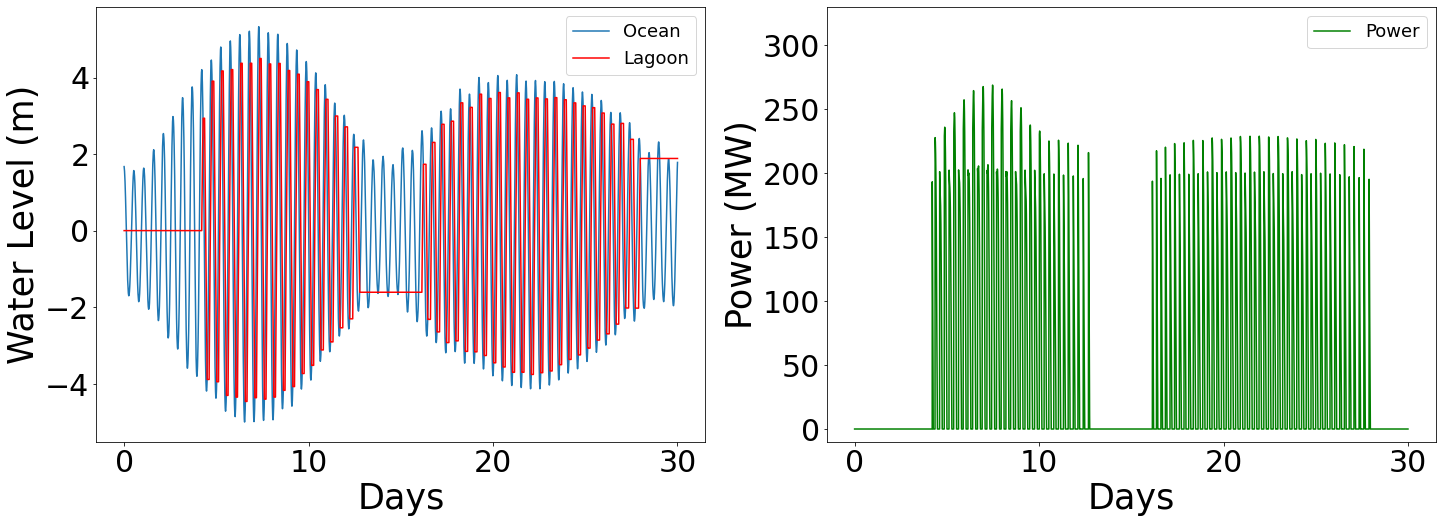

In [69]:
flex = "No"; name = "CH"  
makePlots(CHUpperBoundOcean[0], CHUpperBoundLagoon[0], CHUpperBoundPow[0], flex, name)

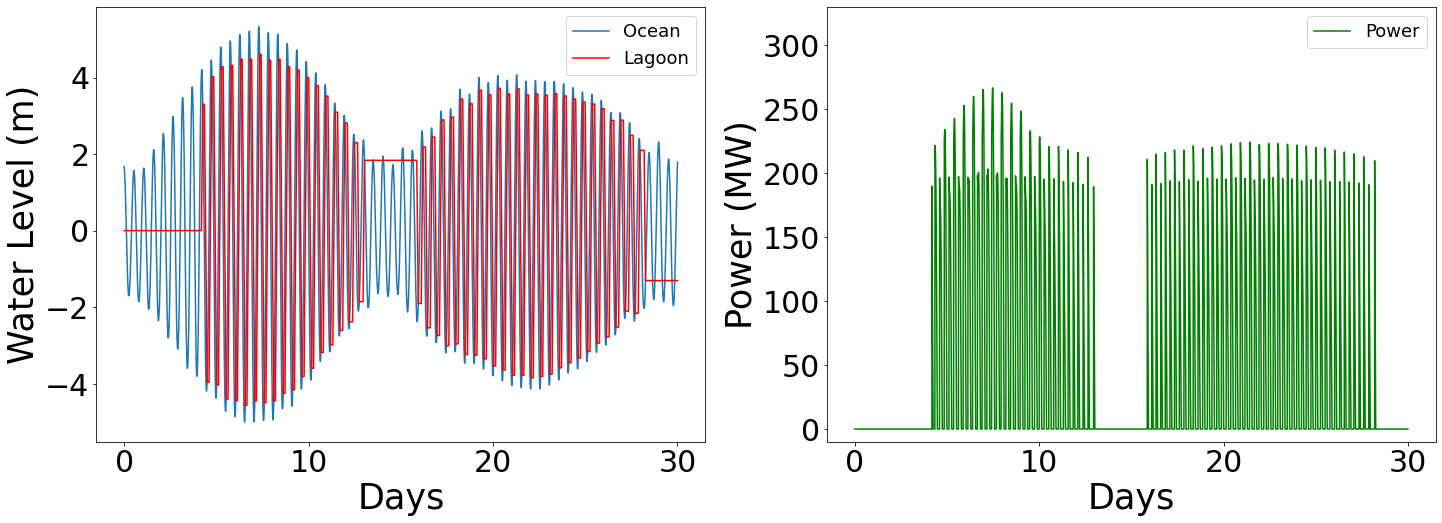

In [70]:
flex = "No";name = "CHV"
makePlots(CHVUpperBoundOcean[0], CHVUpperBoundLagoon[0], CHVUpperBoundPow[0], flex, name)

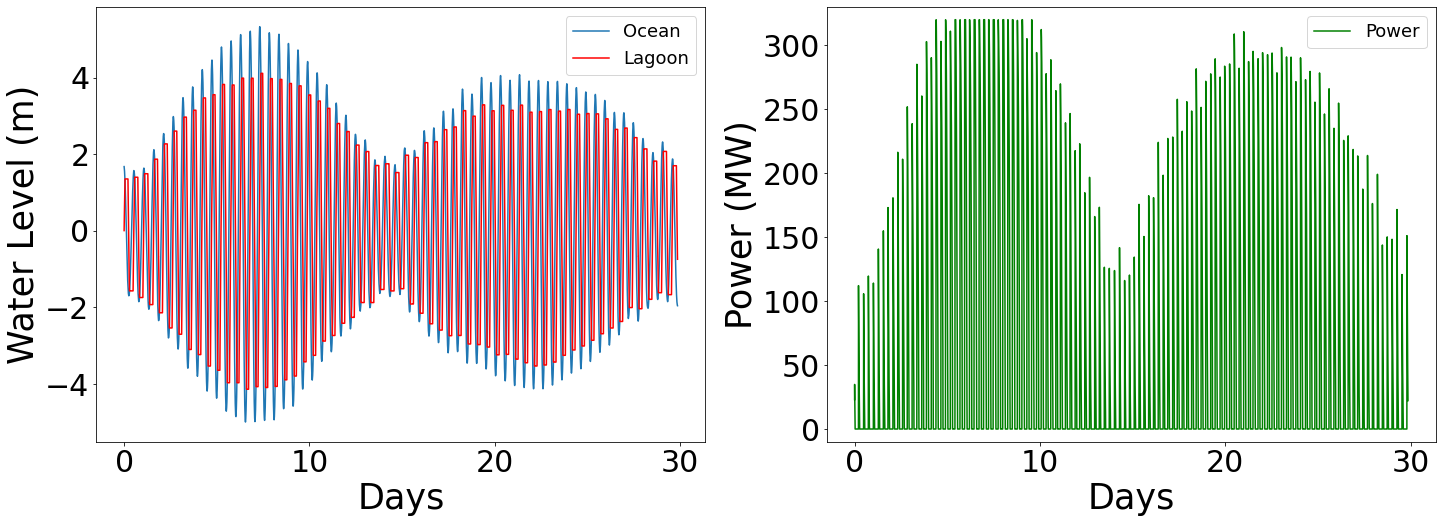

In [68]:
flex = "Yes"; name = "EHT" 
makePlots(EHTUpperBoundOcean[0], EHTUpperBoundLagoon[0], EHTUpperBoundPow[0], flex, name)

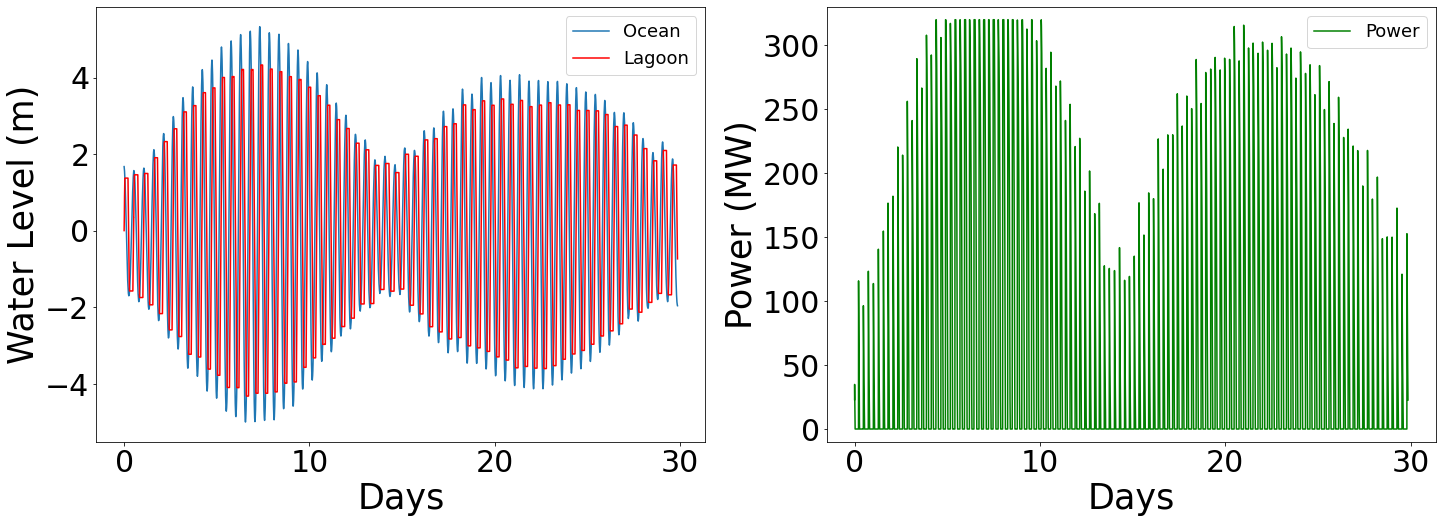

In [67]:
flex = "Yes"; name = "EHTV"
makePlots(EHTVUpperBoundOcean[0], EHTVUpperBoundLagoon[0], EHTVUpperBoundPow[0], flex, name)

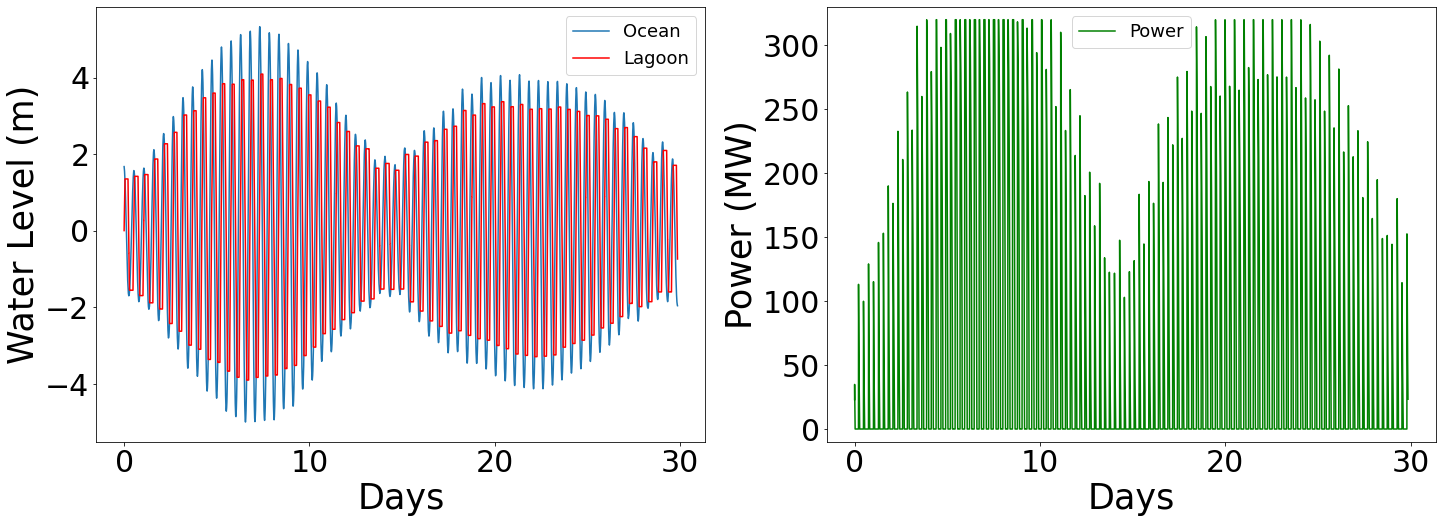

In [66]:
flex = "Yes"; name = "EHN"
makePlots(EHNUpperBoundOcean[0], EHNUpperBoundLagoon[0], EHNUpperBoundPow[0], flex, name)

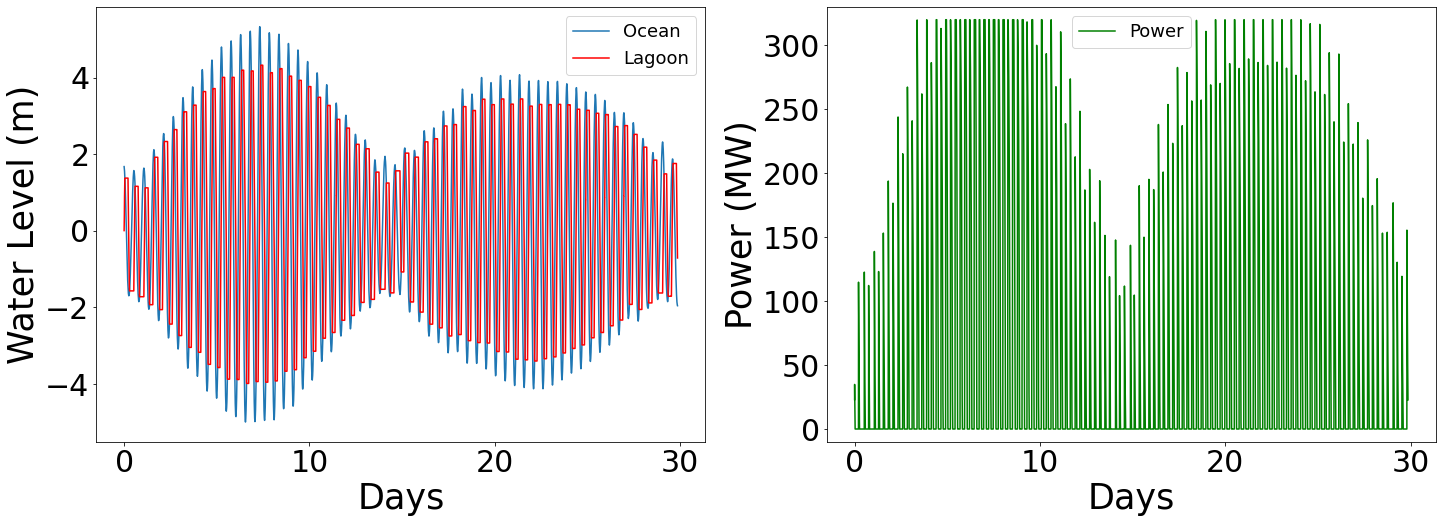

In [65]:
flex = "Yes"; name = "EHNV"
makePlots(EHNVUpperBoundOcean[0], EHNVUpperBoundLagoon[0], EHNVUpperBoundPow[0], flex, name)

## Ocean and Lagoon Water levels, with corresponding Power Generation (Real-Time):

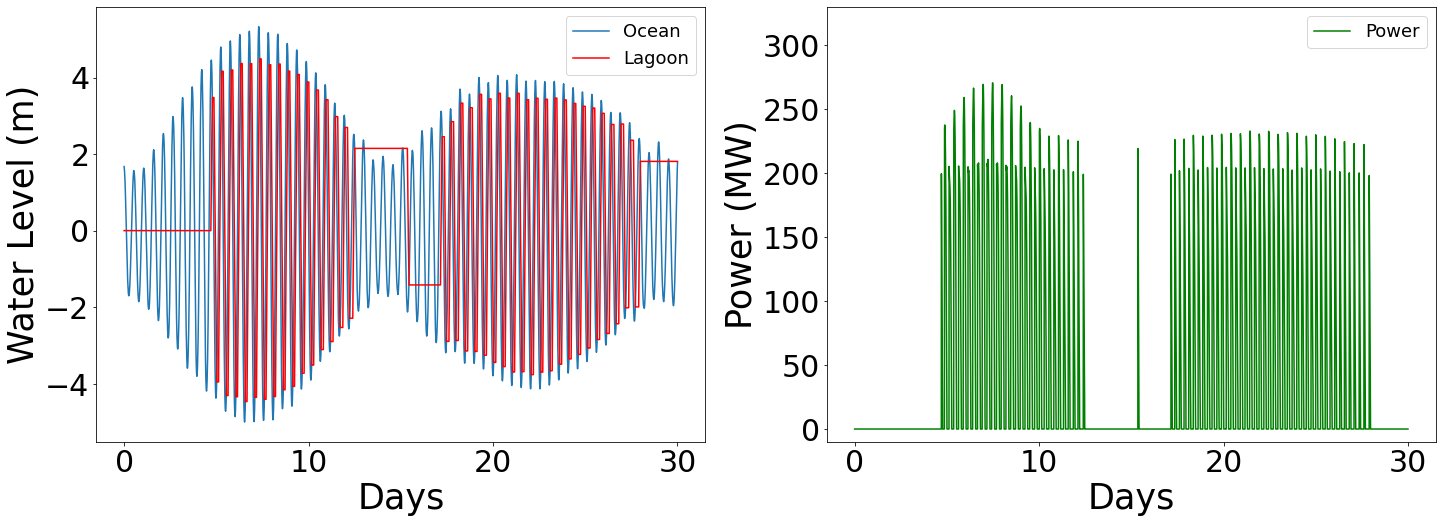

In [81]:
flex = "No"; name = "CH"  
makePlots(CHMonthPredOcean[0], CHMonthPredLagoon[0], CHMonthPredPow[0], flex, name)

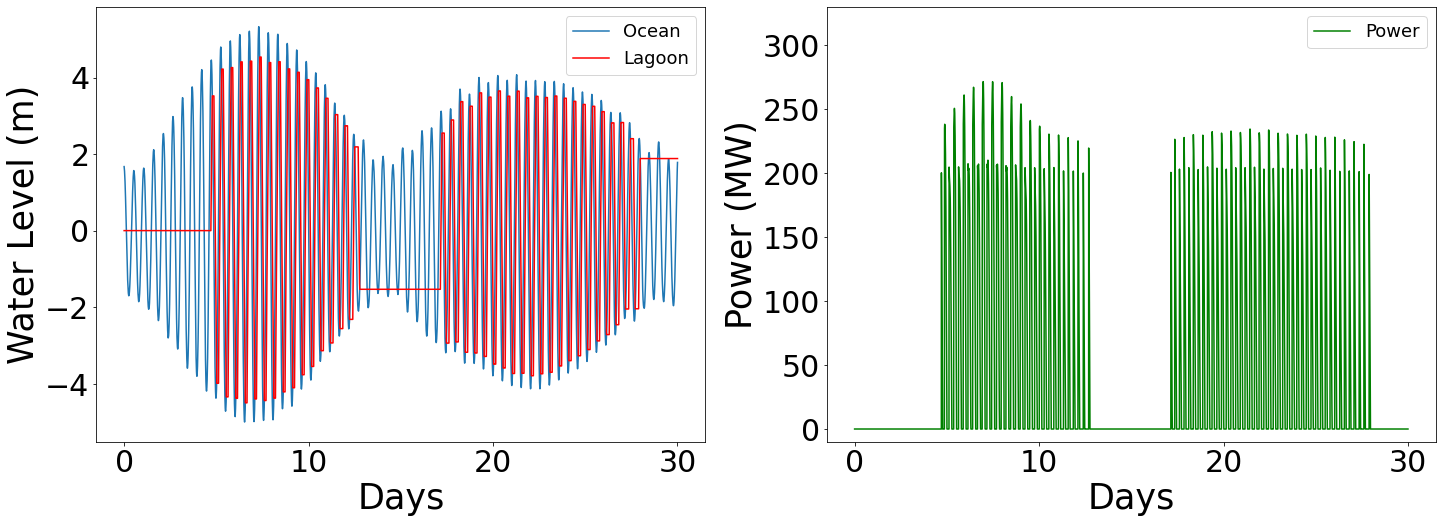

In [82]:
flex = "No";name = "CHV"
makePlots(CHVMonthPredOcean[0], CHVMonthPredLagoon[0], CHVMonthPredPow[0], flex, name)

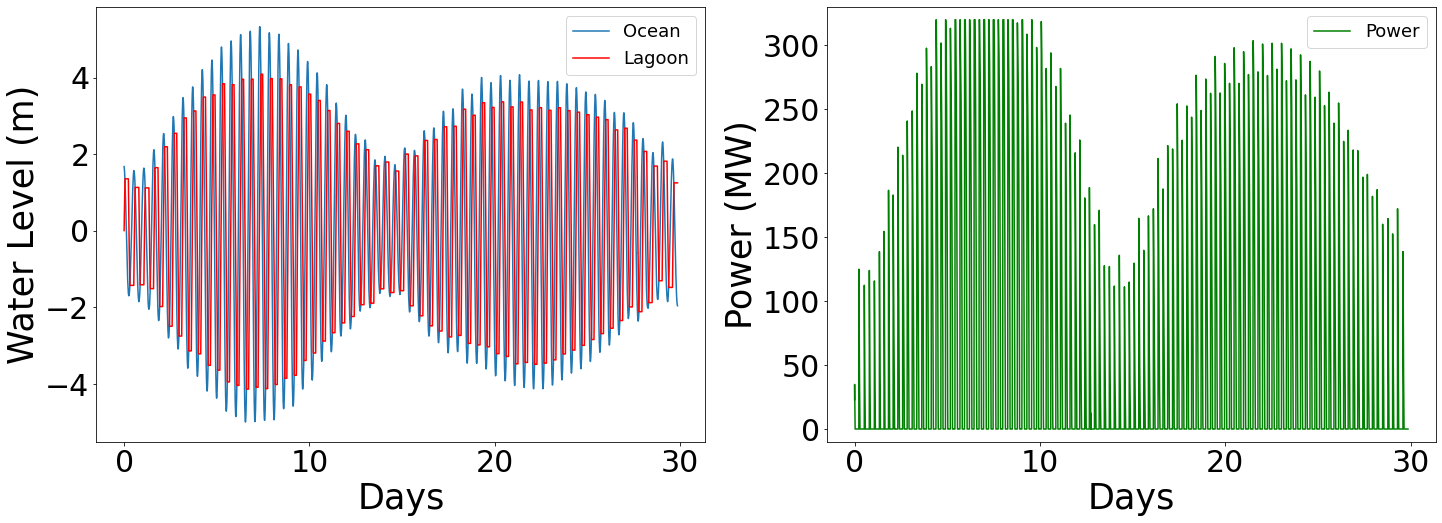

In [83]:
flex = "Yes"; name = "EHT" 
makePlots(EHTMonthPredOcean[0], EHTMonthPredLagoon[0], EHTMonthPredPow[0], flex, name)

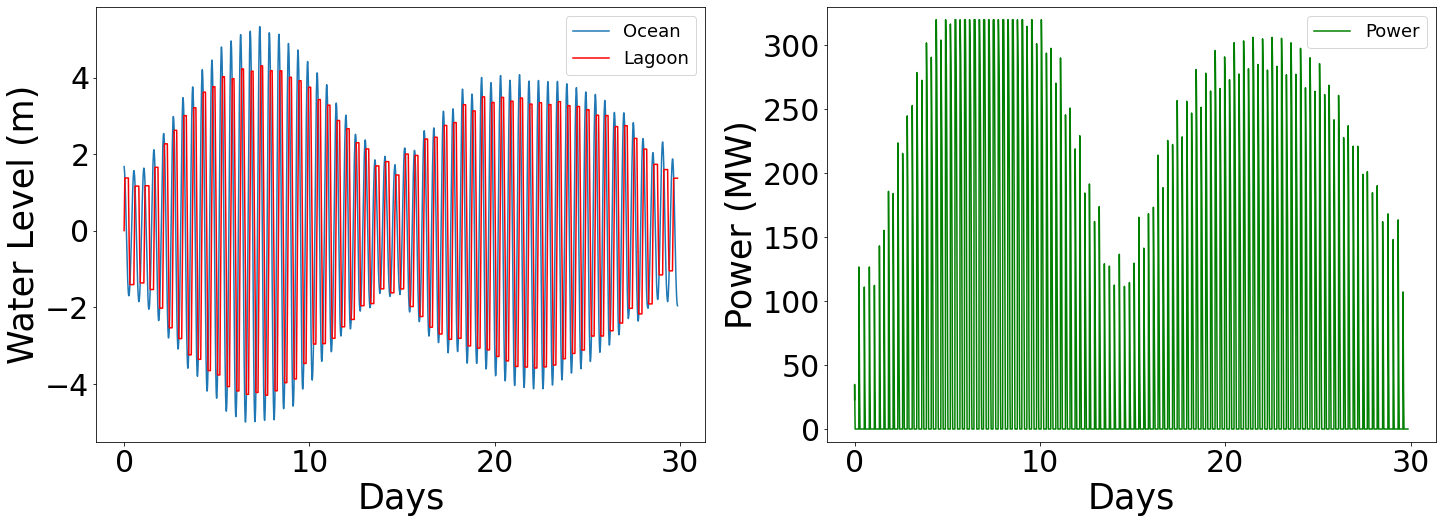

In [84]:
flex = "Yes"; name = "EHTV"
makePlots(EHTVMonthPredOcean[0], EHTVMonthPredLagoon[0], EHTVMonthPredPow[0], flex, name)

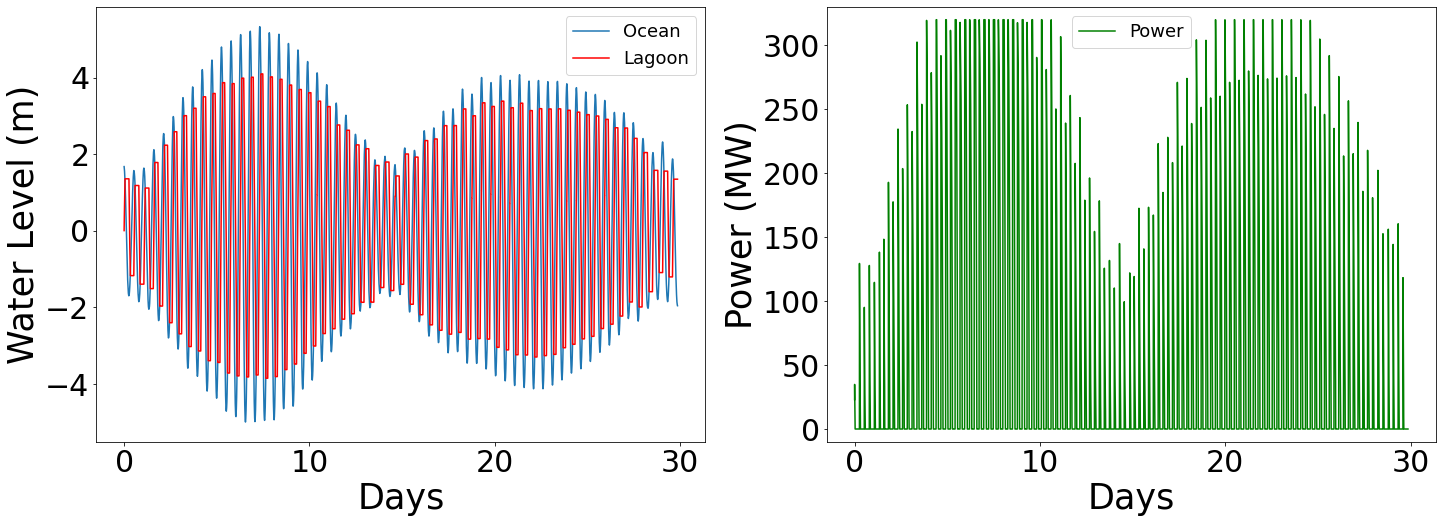

In [85]:
flex = "Yes"; name = "EHN"
makePlots(EHNMonthPredOcean[0], EHNMonthPredLagoon[0], EHNMonthPredPow[0], flex, name)

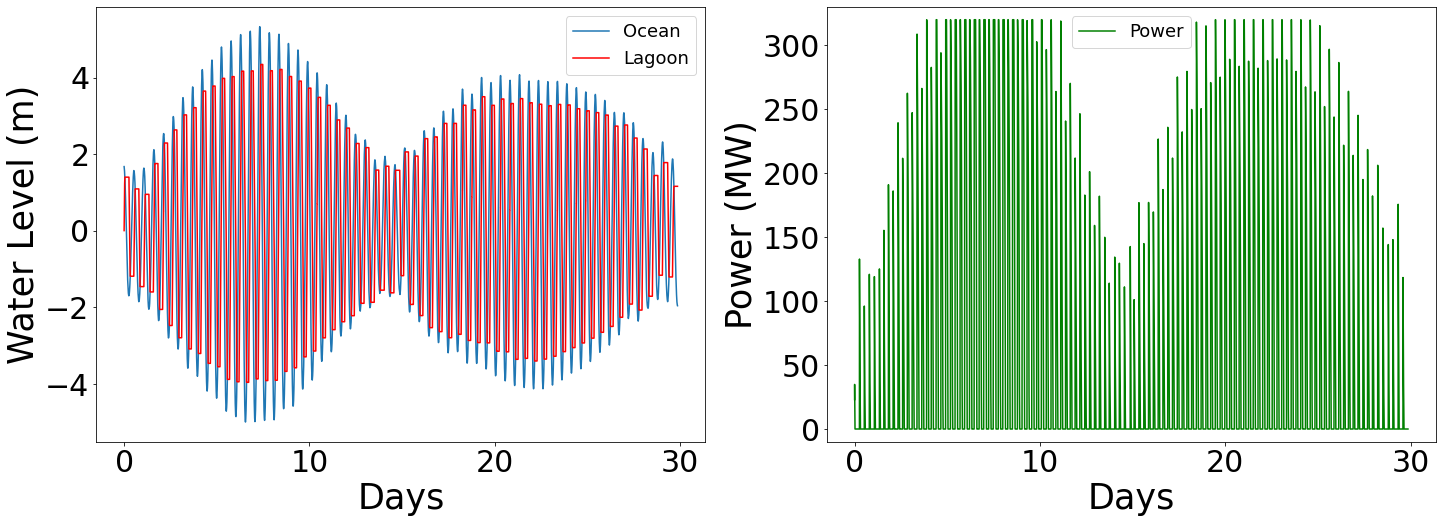

In [86]:
flex = "Yes"; name = "EHNV"
makePlots(EHNVMonthPredOcean[0], EHNVMonthPredLagoon[0], EHNVMonthPredPow[0], flex, name)

# Histograms, comparing the total extracted energy for each method:

## Upper Bound Comparison:

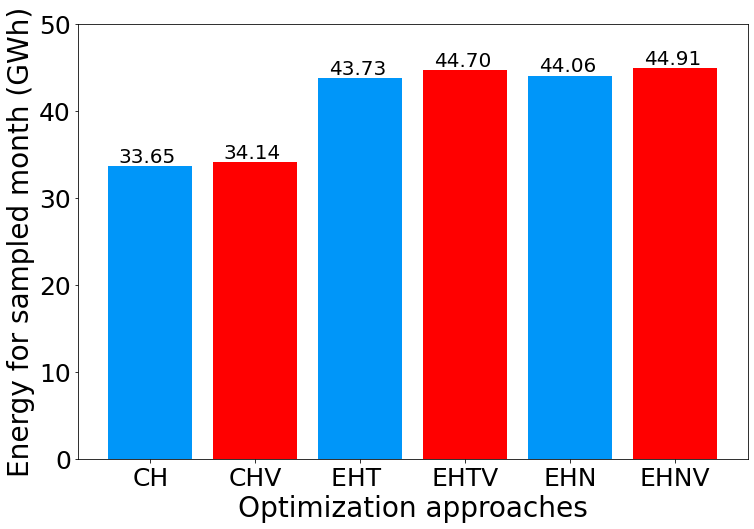

In [88]:
colorB = (0, 150/255, 249/255)
bars = ['CH', 'CHV', 'EHT ', 'EHTV', 'EHN', 'EHNV']
y_pos = np.arange(len(bars))
newV = [CHUpperBoundEn[0], CHVUpperBoundEn[0], EHTUpperBoundEn[0], EHTVUpperBoundEn[0], EHNUpperBoundEn[0], EHNVUpperBoundEn[0]]
fig1 = plt.figure(figsize=[12,8])
plt.bar(y_pos, newV, color=[colorB, 'red', colorB, 'red', colorB, 'red'])
plt.xlabel('Optimization approaches', fontsize = 28)
plt.ylabel('Energy for sampled month (GWh)', fontsize = 28)
plt.xticks(y_pos, bars)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title('Upper Bound Comparison', fontsize=25)
plt.ylim(0,50)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(newV):
    V = "%.2f" % v
    plt.text(xlocs[i] - 0.3, v + 0.5, str(V), fontsize = 20)
plt.show()

## Real-Time Comparison:

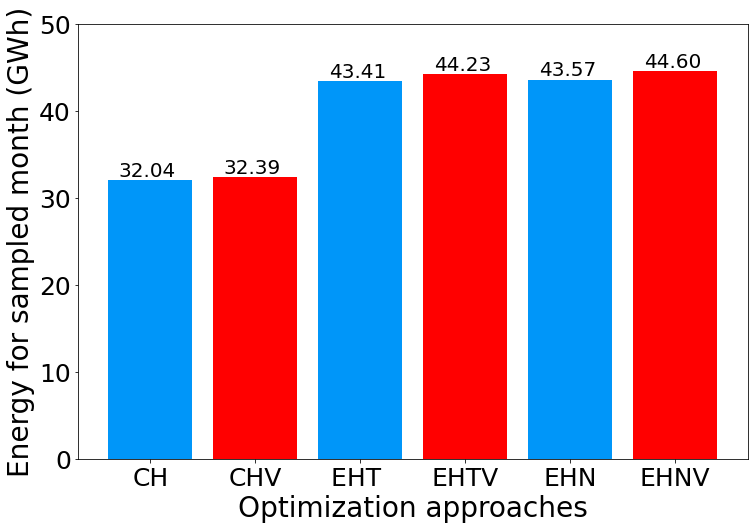

In [87]:
colorB = (0, 150/255, 249/255)
bars = ['CH', 'CHV', 'EHT ', 'EHTV', 'EHN', 'EHNV']
y_pos = np.arange(len(bars))
newV = [CHMonthPredEn[0], CHVMonthPredEn[0], EHTMonthPredEn[0], EHTVMonthPredEn[0], EHNMonthPredEn[0], EHNVMonthPredEn[0]]
fig1 = plt.figure(figsize=[12,8])
plt.bar(y_pos, newV, color=[colorB, 'red', colorB, 'red', colorB, 'red'])
plt.xlabel('Optimization approaches', fontsize = 28)
plt.ylabel('Energy for sampled month (GWh)', fontsize = 28)
plt.xticks(y_pos, bars)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title('Real-Time Comparison', fontsize=25)
plt.ylim(0,50)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(newV):
    V = "%.2f" % v
    plt.text(xlocs[i] - 0.3, v + 0.5, str(V), fontsize = 20)
plt.show()